# Can luminosity distribution explain FRB flux distribution?

In [19]:
%matplotlib inline

In [2]:
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
import astropy.cosmology as cosmo
import astropy.units as u
import multiprocessing
from contextlib import closing

# optimization produces lots of warning that can be ignored
import warnings
warnings.filterwarnings('ignore')

npr = 16 # number of processes for simulation

## Define functions

In [3]:
def simulate(zr, lr, popt, nfrb=1000):
    """ Simulate FRBs over redshift range and luminosity range
    FRB distribution should trace volume and lum distribution
    One FRB per source."""
    
    z_min, z_max = zr
    l_min, l_max = lr
    
    # luminosity grid
    lumsim = np.logspace(np.log10(l_min), np.log10(l_max), 1000)
#    lumbin = np.array([lumsim[i+1]-lumsim[i] for i in range(len(lumsim)-1)] + [lumsim[-1]-lumsim[-2]])
    rate = plaw(lumsim, popt[0]+1, popt[1])  # add 1 to get prob per lum (not cumulative)

    # redshift grid (linear)
    zgrid = np.linspace(z_min, z_max, 1000)
    vols = np.array([co.comoving_volume(zgrid[i+1]).value - co.comoving_volume(zgrid[i]).value
                     for i in range(len(zgrid)-1)])

    # simulate independent sources. one burst per source
    zs = np.random.choice(zgrid[:-1], p=vols/vols.sum(), replace=True, size=nfrb)  # choose redshift with probablility scaling by volume per bin
    lums = np.random.choice(lumsim, p=rate/rate.sum(), replace=True, size=nfrb)  # choose flux with probability scaling by rate
    fluxes = lums/(4*np.pi*co.luminosity_distance(zs).to(u.cm).value**2)  # make a source flux distribution
    fluxes.sort()
    lums.sort()
    
    return zs, fluxes, lums


def model(zs, fluxes, lums, ntop=20, show=True):
    """ Model flux distribution and optionally plots them.
    Returns best fit powerlaw to ntop flux values.
    """
    
    # fit all fluxes (infinite sensitivity)
    cntf = np.arange(1, len(fluxes)+1)[::-1]
    poptf, pcovf = curve_fit(plaw, fluxes, cntf, sigma=np.sqrt(cntf), p0=(0, 1))

    # fit high fluxes (sensitivity limit)
    cnth = np.arange(1, ntop+1)[::-1]
    popth, pcovh = curve_fit(plaw, fluxes[-ntop:], cnth, sigma=np.sqrt(cnth), p0=(0, 1))

    # fit luminosities (to confirm sample is right)
    cntl = np.arange(1, len(lums)+1)[::-1]
#    cntl = np.ones_like(lums)
    poptl, pcovl = curve_fit(plaw, lums, cntl, sigma=np.sqrt(cntl), p0=(0, 1))

    if show:
        print('All: Flux slope {0} and amplitude {1} (at F={2})'.format(poptf[0], poptf[1], fluxes[0]))
        print('Top {0}: flux slope {1} and amplitude {2} (at F={3})'.format(ntop, popth[0], popth[1], fluxes[-ntop]))
        print('Luminosities: slope {0} and amplitude {1} (at L={2})'.format(poptl[0], poptl[1], lums[0]))

        pl.figure(figsize=(12,5))
        pl.subplot(131)
        pl.plot(np.log10(fluxes), np.log10(cntf), 'kx', label='Fluxes')
        pl.plot(np.log10(fluxes), np.log10(plaw(fluxes, *poptf)), '-r',
                label='Index (all): {0:.2f}'.format(poptf[0]))
        pl.plot(np.log10(fluxes[-ntop:]), np.log10(plaw(fluxes[-ntop:], *popth)), '-r',
                label='Index (ntop {0}): {1:.2f}'.format(ntop, popth[0]))
        pl.xlabel('log F (erg/cm2)')
        pl.ylabel('log N (>F)')
#        pl.legend()
        pl.subplot(132)
        pl.hist(zs)
        pl.xlabel('redshift')
        pl.ylabel('FRB count')
        pl.subplot(133)
#        cnt = np.arange(len(lums))[::-1]
#        pl.plot(np.log10(lums), np.log10(cnt), '.')
        cnt, edg = pl.histogram(lums)
        pl.plot(np.log10(edg[:-1]), np.log10(cnt), 'x')
        pl.xlabel('Luminosity')
        pl.ylabel('log N')

    return popth


def simmodel(zr, lr, popt, nfrb, ntop, seed):
    assert nfrb >= ntop, 'Not enough simulations to get ntop {0} fluxes'.format(ntop)
    np.random.seed(seed)
    zs, fluxes, lums = simulate(zr, lr, popt, nfrb)
    popth = model(zs, fluxes, lums, ntop=ntop, show=False)
#    print(seed, popth)
    return popth


def getalphas(res):
    alphas = []    
    while res.keys():
        for i in res.keys():
            if res[i].ready():
                job = res.pop(i)
                try:
                    popth = job.get()
                except RuntimeError:
                    print('curve_fit Runtime Error. Continuing with last result...')
                alphas.append(popth[0])
    alphas = np.array(alphas)
    alphas.sort()
    return alphas

def plotalphas(adict, logx=False, xlabel=None, ylabel=None, title=None):
    for key in adict:
        val = adict[key]
        if logx:
            pl.plot([np.log10(key), np.log10(key)], list(adict[key]), 'k.-' )
        else:
            pl.plot([key, key], list(adict[key]), 'k.-' )
        if title:
            pl.title(title)
        if xlabel:
            pl.xlabel(xlabel)
        if ylabel:
            pl.ylabel(ylabel)

## Model luminosity distribution of FRB 121102

In [4]:
# reference values and functions
lum_s = lambda ld, s: s*1e-23 * (4*np.pi*ld**2) * 5e-3 * 1.024e9 # lum in erg, s in Jy, ld in cm
plaw = lambda x, alpha, a: a*(x/x[0])**alpha  # given array x, return powerlaw relative to first entry

co = cosmo.Planck15
ld0 = co.luminosity_distance(0.193)

lum0 = np.array([1.5, 12, 0.6, 0.4, 2.1, 0.2, 0.4, 0.6, 0.6])* 1e39
lum0.sort()
cnt = np.arange(1,len(lum0)+1)[::-1]

Powerlaw slope -0.595096394487 and amplitude 9.74781765219 (at L=2e+38)


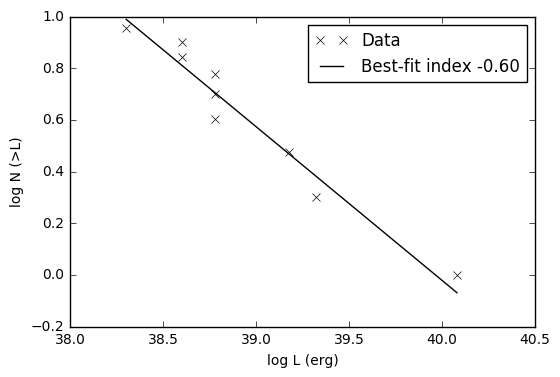

In [5]:
popt0, pcov0 = curve_fit(plaw, lum0, cnt, sigma=np.sqrt(cnt), p0=(-1, 10))
print('Powerlaw slope {0} and amplitude {1} (at L={2})'.format(popt0[0], popt0[1], lum0[0]))

pl.plot(np.log10(lum0), np.log10(cnt), 'kx', label='Data')
pl.plot(np.log10(lum0), np.log10(plaw(lum0, *popt0)), '-k', label='Best-fit index {0:.2f}'.format(popt0[0]))
pl.xlabel('log L (erg)')
pl.ylabel('log N (>L)')
pl.legend()

In [6]:
# model the burst luminosity as a poisson process scaling with a powerlaw rate
def pr(l, alpha, a0):
    lam = plaw(l, alpha, a0)  # powerlaw rate function
    return lam*np.exp(-lam)

# sample over grid of powerlaw parameters
alphas = np.linspace(-1.,0.8,300)
a0s = np.linspace(0.,3.5,300)
probs = np.zeros(shape=(len(alphas), len(a0s)), dtype=float)

for i in range(len(alphas)):
    for j in range(len(a0s)):
        probs[i,j] = np.prod(pr(lum0, alphas[i], a0s[j]))
        
probs = np.ma.masked_invalid(probs)

Peak at: alpha -0.00066889632107, a0 1.00668896321
1 sigma bounds on: alpha -0.488294314381 to 0.402675585284, a0 0.421404682274 to 2.14214046823


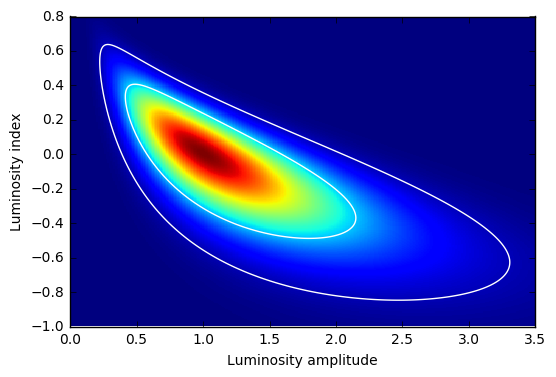

In [7]:
pl.imshow(probs, interpolation='nearest', aspect='auto', 
          origin='lower', extent=(a0s[0], a0s[-1], alphas[0], alphas[-1]))
#pl.colorbar()
X, Y = np.meshgrid(a0s, alphas)
pl.contour(X, Y, probs/probs.max(), [0.05, 0.32], colors='w')
pl.xlabel('Luminosity amplitude')
pl.ylabel('Luminosity index')

i0, j0 = np.where(probs == probs.max())
print('Peak at: alpha {0}, a0 {1}'.format(alphas[i0][0], a0s[j0][0]))
popt1 = (alphas[i0][0], a0s[j0][0])

i1sig, j1sig = np.where(probs >= (1-0.68)*probs.max())
print('1 sigma bounds on: alpha {0} to {1}, a0 {2} to {3}'.format(alphas[i1sig].min(),
                                                                  alphas[i1sig].max(),
                                                                  a0s[j1sig].min(),
                                                                  a0s[j1sig].max()))

## Simulation example using "standard candle" FRB

All: Flux slope -1.32317309102 and amplitude 2040.48677394 (at F=3.70843685138e-16)
Top 20: flux slope -1.27062486231 and amplitude 20.8248136914 (at F=1.12948038784e-14)
Luminosities: slope -292.50263339 and amplitude 2779.16169473 (at L=1.00000996034e+40)


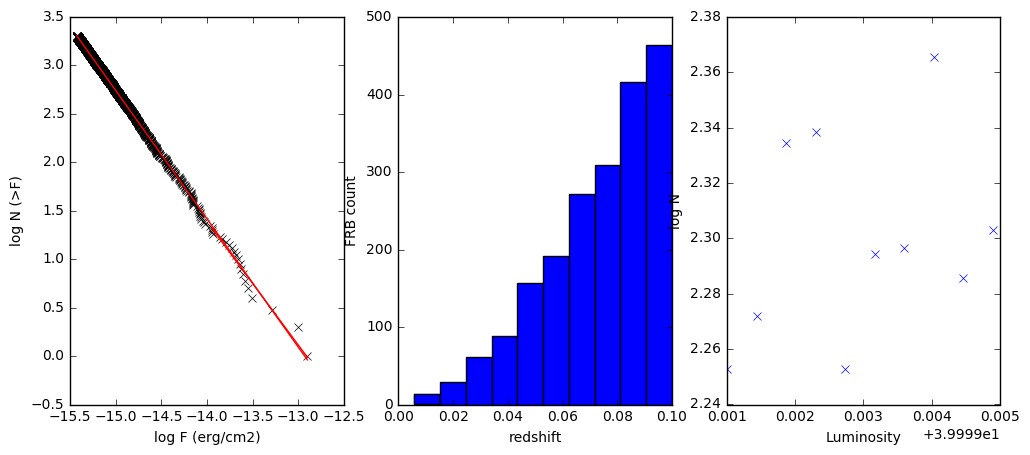

In [8]:
# example using standard candle
zr = 0., 0.1
lr = 1e40, 1.01e40
ntop = 20
nfrb = 2000
popt_std = (0, 10)
zs, fluxes, lums = simulate(zr, lr, popt_std, nfrb=nfrb)
popth = model(zs, fluxes, lums, ntop=ntop)

## Standard candle evolution with z_max
### Confirms Euclidean -3/2 powerlaw a low z

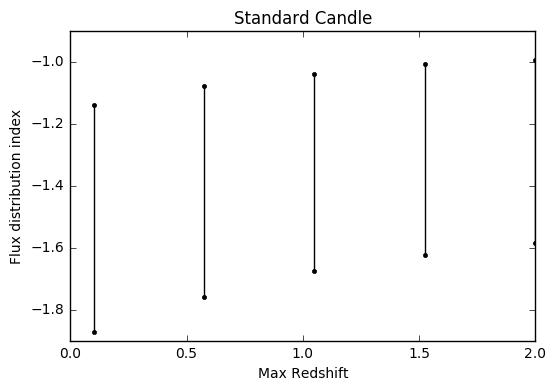

In [9]:
lr = 1e35, 1.01e35
popt_std = (0, 10)
z_min = 0.
ntr = 100
nfrb = 2000
ntop = 20
ci = 0.68

a_std = {}
for z_max in np.linspace(0.1, 2., 5):
#    zs, fluxes, lums = simulate((z_min, z_max), lr, popt_std, nfrb=100)
#    popth = model(zs, fluxes, lums, show=False)
#    alphas.append(popth[0])

    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, ( (z_min, z_max), lr, popt_std, nfrb, ntop, trial))
        alphas = getalphas(res)
        
    a_std[z_max] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

plotalphas(a_std, title='Standard Candle', xlabel='Max Redshift', ylabel='Flux distribution index')

## Grow standard candle to distribution
### Need a luminosity range of >7 orders of magnitude for stable index measurement (non-standard candle behavior)

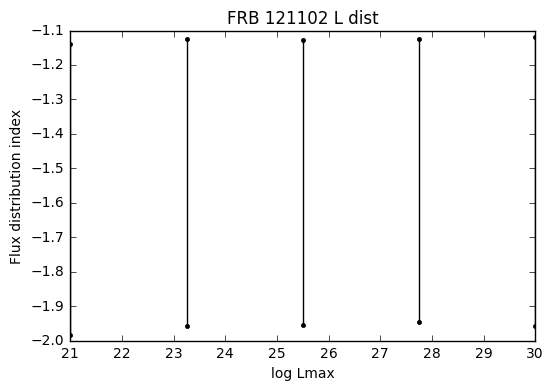

In [10]:
l_min = 1e20
zr = 0., 0.01
ntr = 100
nfrb = 2000
ntop = 20
ci = 0.68

a_lmax = {}
for l_max in np.logspace(np.log10(l_min)+1, np.log10(l_min)+10, 5):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, ( zr, (l_min, l_max), popt1, nfrb, ntop, trial))
        alphas = getalphas(res)

    a_lmax[l_max] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])
    
plotalphas(a_lmax, logx=True, title='FRB 121102 L dist', xlabel='log Lmax', ylabel='Flux distribution index')

## Test sensitivity to number of FRBs simulated
### Sample needs to be > xx for reliable simulation of 20 bursts?

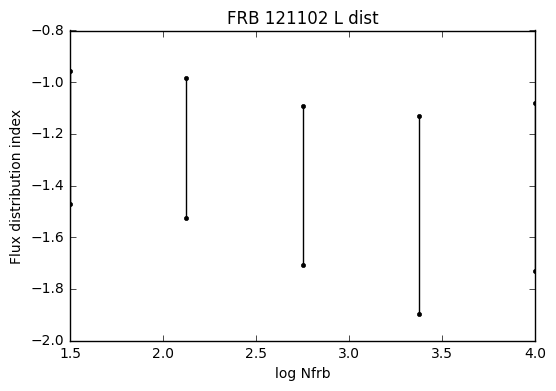

In [11]:
l_min = 1e35, 1e45
zr = 0., 0.4
ntr = 100
ntop = 20
ci = 0.68
a_nfrb = {}
for nfrb in np.logspace(1.5,4,5):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, (zr, lr, popt1, int(nfrb), ntop, trial))
        alphas = getalphas(res)

    a_nfrb[nfrb] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])
    
plotalphas(a_nfrb, logx=True, title='FRB 121102 L dist', xlabel='log Nfrb', ylabel='Flux distribution index')

## Test sensitivity to number of FRBs above "flux limit"
### Observed sample has strong impact on variance of flux distribution, as expected

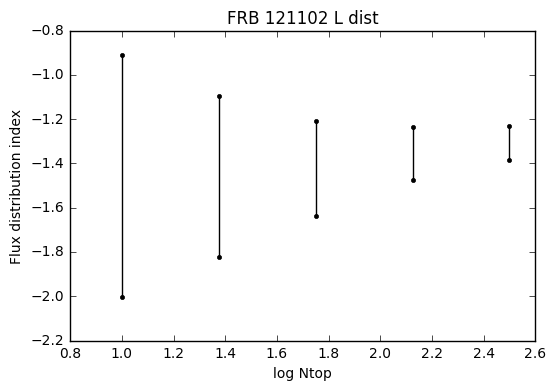

In [12]:
lr = 1e35, 1e45
zr = 0., 0.4
ntr = 100
nfrb = 2000
ci = 0.68
a_ntop = {}
for ntop in np.logspace(1,2.5,5):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, (zr, lr, popt1, nfrb, int(ntop), trial))
        alphas = getalphas(res)

    a_ntop[ntop] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])
    
plotalphas(a_ntop, logx=True, title='FRB 121102 L dist', xlabel='log Ntop', ylabel='Flux distribution index')

## Change input luminosity powerlaw
### For reasonable simulation parameters, the input luminosity index has strong effect on observed flux distribution

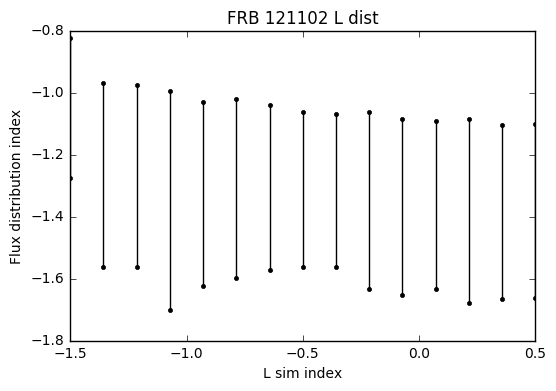

In [13]:
lr = 1e38, 1e42
zr = 0., 0.4
ntr = 100
nfrb = 1000
ntop = 20
ci = 0.68

a_alpha = {}
for alpha_sim in np.linspace(-1.5,0.5,15):
    res = {}
    with closing(multiprocessing.Pool(npr)) as pool:
        for trial in range(ntr):
            res[trial] = pool.apply_async(simmodel, (zr, lr, (alpha_sim, popt1[1]), nfrb, ntop, trial))
        alphas = getalphas(res)

    a_alpha[alpha_sim] = (alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)])

plotalphas(a_alpha, title='FRB 121102 L dist', xlabel='L sim index', ylabel='Flux distribution index')

## Single 95% confidence intervals with parameters safe from edge effects

In [14]:
lr = 1e35, 1e45  # safe from edge effects
zr = 0., 0.4  # safe from edge effects
ntr = 1000  # better 95% bound measurement
nfrb = 2000  # safe from edge effects?
ntop = 20  # set to ball park of current FRB count
ci = 0.95

res = {}
with closing(multiprocessing.Pool(npr)) as pool:
    for trial in range(ntr):
        res[trial] = pool.apply_async(simmodel, (zr, lr, popt1, nfrb, ntop, trial))
    alphas = getalphas(res)

95% ci: -2.34281654491 to -0.86311691265
68% ci: -1.78652141303 to -1.06599573059
Example distribution:
All: Flux slope -0.403966347669 and amplitude 8136.29883844 (at F=3.00915709944e-15)
Top 20: flux slope -0.885921841174 and amplitude 17.7814925303 (at F=3.24594904052e-11)
Luminosities: slope -0.505960740934 and amplitude 7398.90518283 (at L=1.25053858729e+42)


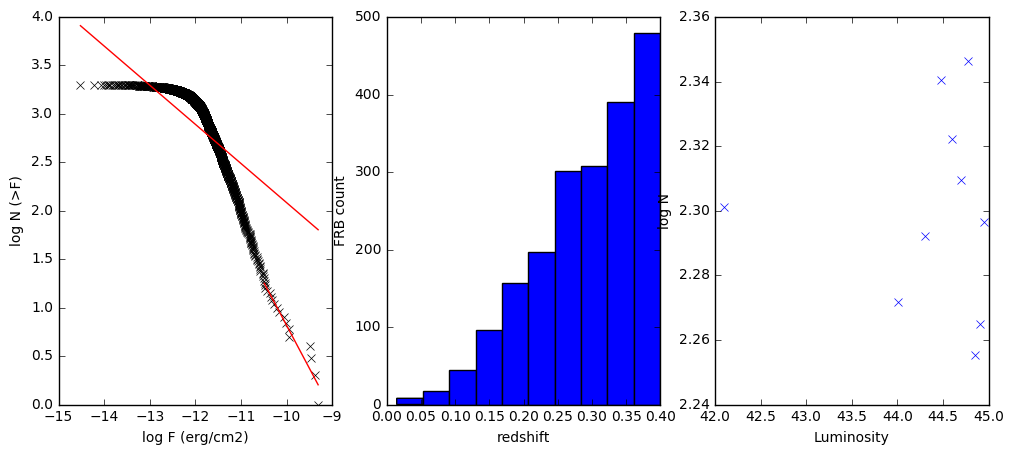

In [15]:
ci = 0.95
print('95% ci: {0} to {1}'.format(alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)]))
ci = 0.68
print('68% ci: {0} to {1}'.format(alphas[ntr/2 - int(ntr*ci/2.)], alphas[ntr/2 + int(ntr*ci/2.)]))
print('Example distribution:')
zs, fluxes, lums = simulate(zr, lr, popt1, nfrb)
popth = model(zs, fluxes, lums, ntop=ntop, show=True)

All: Flux slope -0.673970608485 and amplitude 2567.29783547 (at F=1.71427353979e-22)
Top 20: flux slope -0.621794997323 and amplitude 17.4247408073 (at F=5.6894266313e-20)
Luminosities: slope -0.979055481891 and amplitude 1998.45203537 (at L=1e+35)


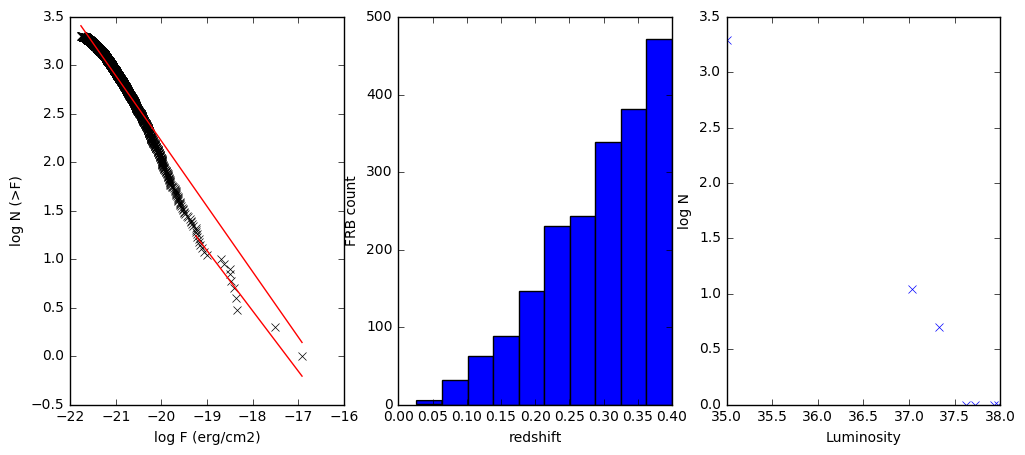

In [16]:
zs, fluxes, lums = simulate(zr, lr, (-2, 10), nfrb)
popth = model(zs, fluxes, lums, show=True)

All: Flux slope -0.382583986359 and amplitude 7441.07322632 (at F=2.52551792569e-15)
Top 20: flux slope -1.06225323781 and amplitude 19.2262700406 (at F=3.29067092896e-11)
Luminosities: slope -0.463981465141 and amplitude 9653.52766004 (at L=4.0420958398e+41)


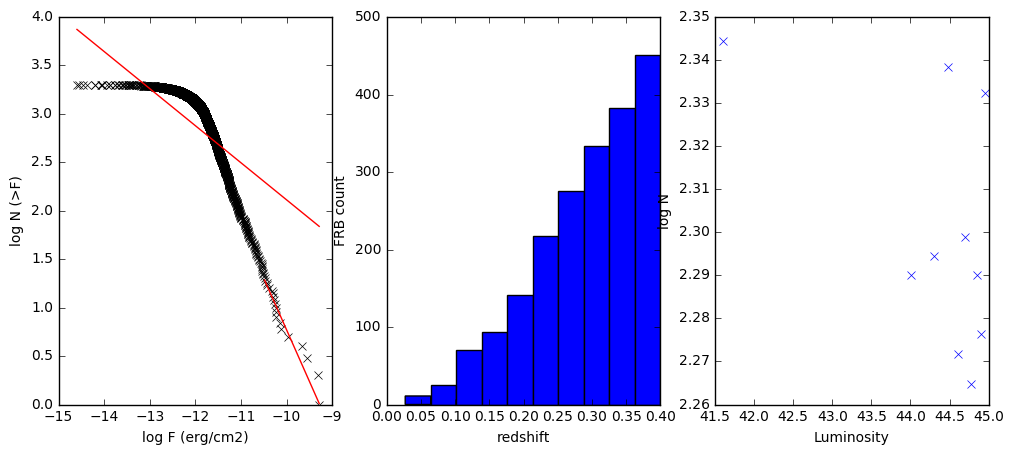

In [17]:
zs, fluxes, lums = simulate(zr, lr, (0, 10), nfrb)
popth = model(zs, fluxes, lums, show=True)

All: Flux slope -0.638219376099 and amplitude 11290.610542 (at F=3.34286320222e-14)
Top 20: flux slope -1.9755375212 and amplitude 20.4569717185 (at F=4.82764929348e-11)
Luminosities: slope -0.805679830077 and amplitude 10558.4720612 (at L=1.01861017016e+43)


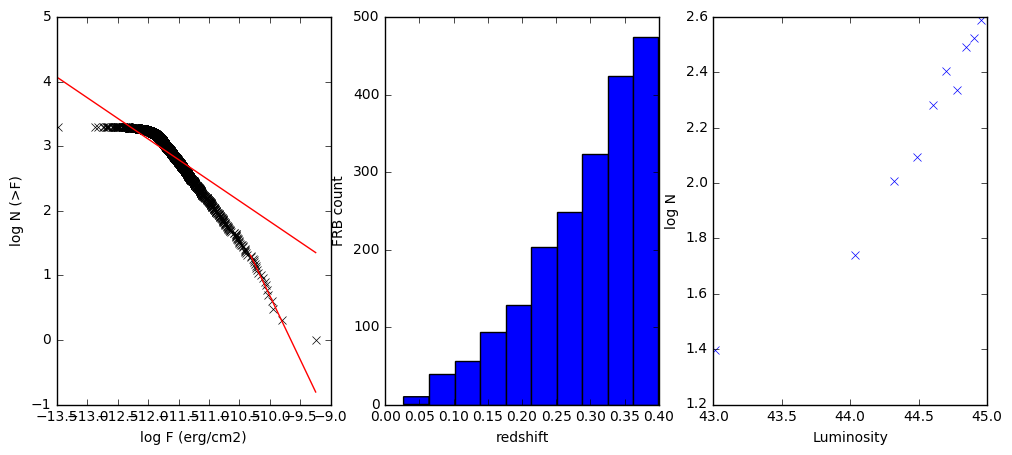

In [18]:
zs, fluxes, lums = simulate(zr, lr, (1, 10), nfrb)
popth = model(zs, fluxes, lums, show=True)